<a href="https://colab.research.google.com/github/gokul-pv/EVA6_Assignments_Session10/blob/main/PartA/EVA6_Session_10_TinyImageNet_Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-gep9t5zx
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-gep9t5zx
  Created wheel for albumentations: filename=albumentations-1.0.3-py3-none-any.whl size=98755 sha256=2422dfa1f5a88a62f2ef8d8df5d6eadb5330004d46f9273d773f65b2198be983
  Stored in directory: /tmp/pip-ephem-wheel-cache-9as_mrui/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
%cd /content
!/usr/local/cuda/bin/nvcc --version
!git clone https://github.com/gokul-pv/MyMainRepo

/content
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
Cloning into 'MyMainRepo'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 229 (delta 111), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (229/229), 65.41 KiB | 7.27 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [3]:
%matplotlib inline

print('importing...')
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import albumentations as A
import albumentations.pytorch as AP
import random
import cv2

print('Done!')

importing...
Done!


In [4]:
%cd MyMainRepo/

/content/MyMainRepo


In [5]:
import models
import main as m
import utils as ut

import dataset as ds

In [6]:
channel_means = (0.442,0.442,0.442)
channel_stdevs = (0.278, 0.278, 0.278)
train_transform = ut.AlbumentationTransforms([                                
                                      A.HorizontalFlip(p = 0.7),
                                      A.PadIfNeeded(min_height=70, min_width=70, border_mode=4, value=None, mask_value=None, always_apply=False, p=1.0),
                                      A.RandomCrop(64, 64, always_apply=False, p=1.0),
                                      A.CoarseDropout(max_holes=1,min_holes = 1, max_height=32, max_width=32, p=0.7,
                                                      fill_value=tuple([x * 255.0 for x in channel_means]),
                                                      min_height=32, min_width=32),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                       ])
test_transform = ut.AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [7]:
train_dataset , test_dataset,classes = ds.TinyImageNetDataSet(train_split = 70,test_transforms = test_transform,train_transforms = train_transform)

In [8]:
len(train_dataset), len(test_dataset), 

(77000, 33000)

**Viewing the applies transformations**

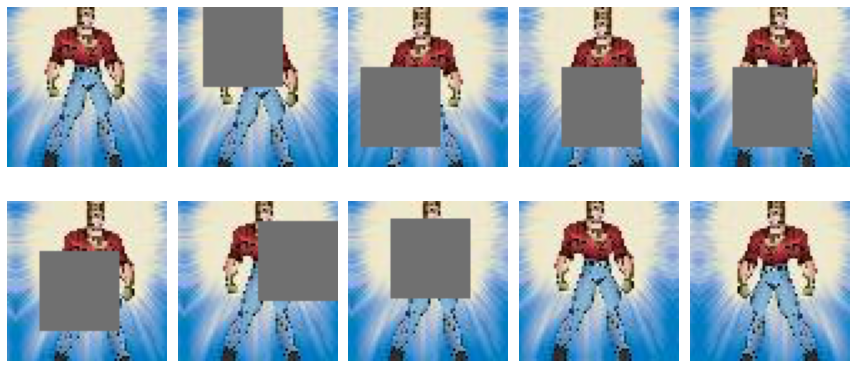

In [9]:
random.seed(42)
ut.visualize_augmentations(train_dataset,train_transform,5 )

In [10]:
trainloader, testloader = m.load(train_dataset,test_dataset,batch_size=256)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2. Define a Convolution Neural Network




In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.ResNet18(num_classes=200).to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1,

In [13]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

learningRates = []
epochs=30

max_epoch = 5
lr = 0.01

In [14]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay = 0.0001,nesterov = True ) 
scheduler = OneCycleLR(optimizer, max_lr = 0.02, total_steps=None, epochs=epochs, steps_per_epoch=len(trainloader), 
                       pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, 
                       div_factor=10.0,final_div_factor =10)


In [15]:
for epoch in range(epochs):
  print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])
  m.train(model, device, trainloader, optimizer, scheduler, criterion, epoch,train_losses,train_accuracy )
  m.test(model, device, criterion, testloader,test_losses, test_accuracy )
  for param_group in optimizer.param_groups:
    learningRates.append(param_group['lr']) 

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.002


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=4.193744659423828 Batch_id=300 Accuracy=5.55: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 2974/33000 (9.01%)

EPOCH: 2 LR: 0.0038005982053838485


Loss=3.761247158050537 Batch_id=300 Accuracy=13.85: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 5008/33000 (15.18%)

EPOCH: 3 LR: 0.005601196410767697


Loss=3.4212605953216553 Batch_id=300 Accuracy=19.84: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0138, Accuracy: 6542/33000 (19.82%)

EPOCH: 4 LR: 0.007401794616151546


Loss=3.300711154937744 Batch_id=300 Accuracy=24.61: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 7768/33000 (23.54%)

EPOCH: 5 LR: 0.009202392821535395


Loss=3.1839206218719482 Batch_id=300 Accuracy=28.59: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 9358/33000 (28.36%)

EPOCH: 6 LR: 0.011002991026919245


Loss=2.993387460708618 Batch_id=300 Accuracy=31.91: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Accuracy: 8913/33000 (27.01%)

EPOCH: 7 LR: 0.012803589232303092


Loss=2.7723305225372314 Batch_id=300 Accuracy=34.53: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 9544/33000 (28.92%)

EPOCH: 8 LR: 0.01460418743768694


Loss=2.484865188598633 Batch_id=300 Accuracy=36.93: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 10183/33000 (30.86%)

EPOCH: 9 LR: 0.01640478564307079


Loss=2.4606924057006836 Batch_id=300 Accuracy=39.35: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Accuracy: 11199/33000 (33.94%)

EPOCH: 10 LR: 0.01820538384845464


Loss=2.6643524169921875 Batch_id=300 Accuracy=41.15: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0108, Accuracy: 11896/33000 (36.05%)

EPOCH: 11 LR: 0.01999671096345515


Loss=2.326511859893799 Batch_id=300 Accuracy=43.18: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 12468/33000 (37.78%)

EPOCH: 12 LR: 0.01900671096345515


Loss=2.2425622940063477 Batch_id=300 Accuracy=45.30: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0101, Accuracy: 12887/33000 (39.05%)

EPOCH: 13 LR: 0.01801671096345515


Loss=2.0580687522888184 Batch_id=300 Accuracy=47.00: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 13103/33000 (39.71%)

EPOCH: 14 LR: 0.01702671096345515


Loss=2.1617488861083984 Batch_id=300 Accuracy=49.09: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 14540/33000 (44.06%)

EPOCH: 15 LR: 0.01603671096345515


Loss=2.0399906635284424 Batch_id=300 Accuracy=50.62: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 14351/33000 (43.49%)

EPOCH: 16 LR: 0.01504671096345515


Loss=1.9319827556610107 Batch_id=300 Accuracy=52.05: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 14944/33000 (45.28%)

EPOCH: 17 LR: 0.014056710963455149


Loss=1.6608678102493286 Batch_id=300 Accuracy=53.70: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 14892/33000 (45.13%)

EPOCH: 18 LR: 0.01306671096345515


Loss=1.881971001625061 Batch_id=300 Accuracy=55.25: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 14973/33000 (45.37%)

EPOCH: 19 LR: 0.012076710963455148


Loss=1.6770224571228027 Batch_id=300 Accuracy=56.84: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 15783/33000 (47.83%)

EPOCH: 20 LR: 0.011086710963455149


Loss=1.6732585430145264 Batch_id=300 Accuracy=58.30: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 16115/33000 (48.83%)

EPOCH: 21 LR: 0.010096710963455147


Loss=1.6595666408538818 Batch_id=300 Accuracy=59.64: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 15705/33000 (47.59%)

EPOCH: 22 LR: 0.00910671096345515


Loss=1.4669309854507446 Batch_id=300 Accuracy=61.55: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 16095/33000 (48.77%)

EPOCH: 23 LR: 0.008116710963455148


Loss=1.6893534660339355 Batch_id=300 Accuracy=62.91: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 16108/33000 (48.81%)

EPOCH: 24 LR: 0.00712671096345515


Loss=1.480400800704956 Batch_id=300 Accuracy=64.75: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 16445/33000 (49.83%)

EPOCH: 25 LR: 0.006136710963455149


Loss=1.2107820510864258 Batch_id=300 Accuracy=66.07: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 17323/33000 (52.49%)

EPOCH: 26 LR: 0.005146710963455148


Loss=1.2747420072555542 Batch_id=300 Accuracy=67.97: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 17377/33000 (52.66%)

EPOCH: 27 LR: 0.00415671096345515


Loss=1.1309386491775513 Batch_id=300 Accuracy=70.35: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 17878/33000 (54.18%)

EPOCH: 28 LR: 0.0031667109634551487


Loss=1.0643219947814941 Batch_id=300 Accuracy=72.68: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 18242/33000 (55.28%)

EPOCH: 29 LR: 0.002176710963455151


Loss=1.030601143836975 Batch_id=300 Accuracy=75.11: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 18565/33000 (56.26%)

EPOCH: 30 LR: 0.0011867109634551495


Loss=0.9878716468811035 Batch_id=300 Accuracy=77.83: 100%|██████████| 301/301 [02:38<00:00,  1.90it/s]



Test set: Average loss: 0.0070, Accuracy: 18991/33000 (57.55%)



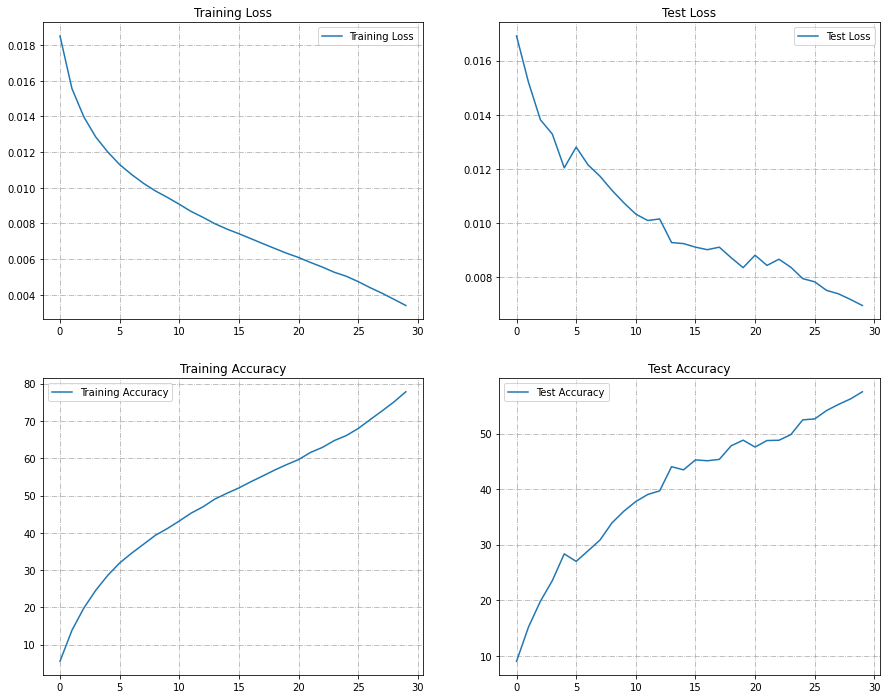

In [16]:
ut.plot_loss_accurracy(train_losses, train_accuracy, test_losses, test_accuracy)

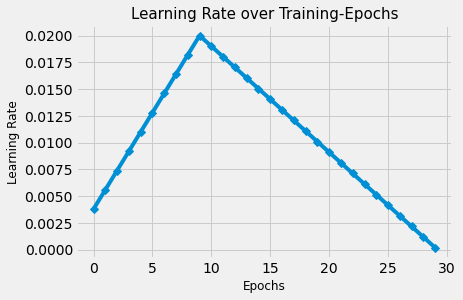

In [17]:
with plt.style.context('fivethirtyeight'):
  plt.plot(learningRates, '-D')
  plt.xlabel('Epochs', fontsize=12)
  plt.ylabel('Learning Rate', fontsize=12)
  plt.title('Learning Rate over Training-Epochs',fontsize=15)

In [18]:
url = "tiny-imagenet-200/words.txt"
f = open(url, "r")
words = [None] * 200
for line in f:
  wordclass = line.strip('\n').split('\t')[0]

  if wordclass in classes:
    i = classes.index(line.strip('\n').split('\t')[0])
    words[i] = line.strip('\n').split('\t')[1]

In [19]:
misclassified_images = []
correct_pred = {classname: 0 for classname in words}
total_pred = {classname: 0 for classname in words}

ut.evaluate_accuracy(model,device,testloader,misclassified_images,words, correct_pred, total_pred )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Plotting the misclassified image

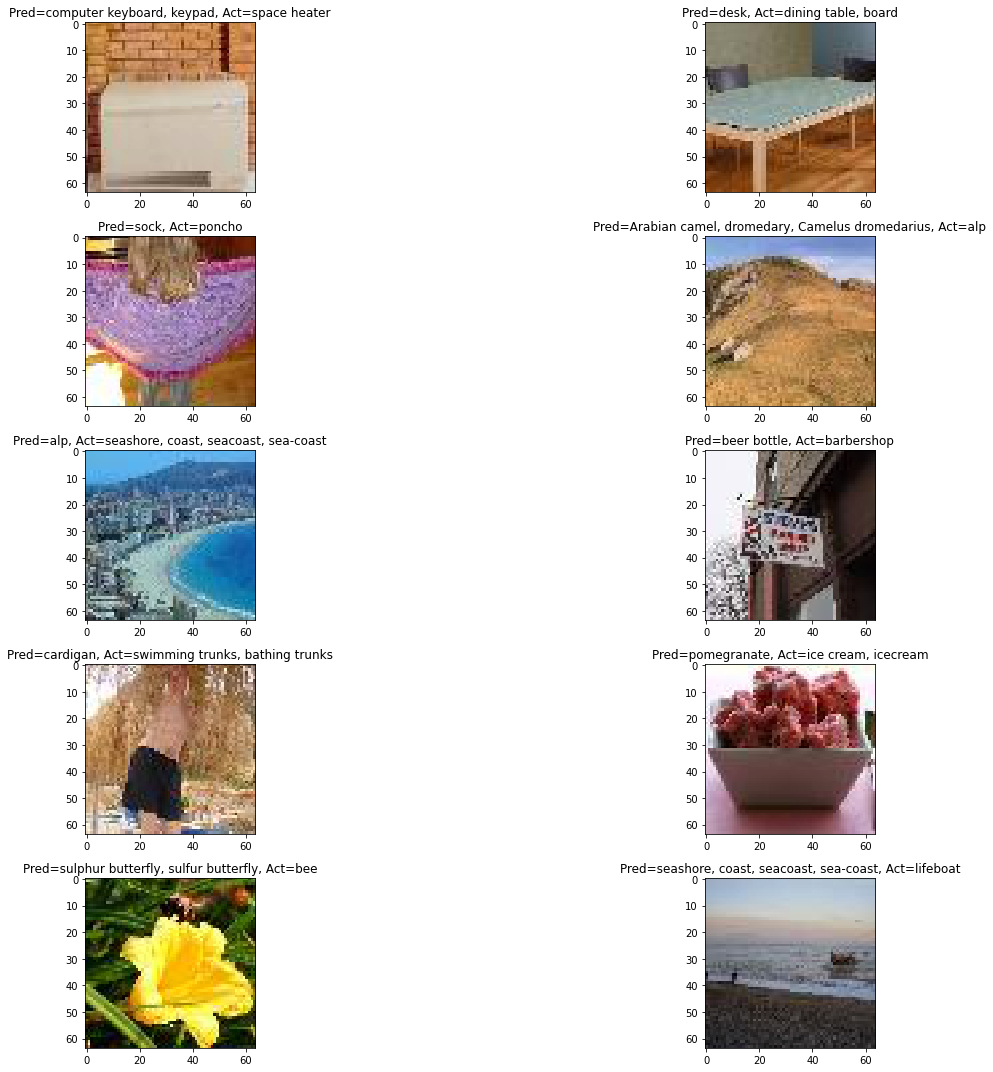

Accuracy for class Egyptian cat is: 49.7 %
Accuracy for class reel  is: 29.1 %
Accuracy for class volleyball is: 70.8 %
Accuracy for class rocking chair, rocker is: 51.7 %
Accuracy for class lemon is: 69.5 %
Accuracy for class bullfrog, Rana catesbeiana is: 62.5 %
Accuracy for class basketball is: 68.8 %
Accuracy for class cliff, drop, drop-off is: 55.7 %
Accuracy for class espresso is: 79.2 %
Accuracy for class plunger, plumber's helper is: 18.4 %
Accuracy for class parking meter is: 49.7 %
Accuracy for class German shepherd, German shepherd dog, German police dog, alsatian is: 63.5 %
Accuracy for class dining table, board is: 61.7 %
Accuracy for class monarch, monarch butterfly, milkweed butterfly, Danaus plexippus is: 90.4 %
Accuracy for class brown bear, bruin, Ursus arctos is: 64.6 %
Accuracy for class school bus is: 79.1 %
Accuracy for class pizza, pizza pie is: 78.6 %
Accuracy for class guinea pig, Cavia cobaya is: 61.3 %
Accuracy for class umbrella is: 29.9 %
Accuracy for class

In [20]:
ut.show_misclassified_images(misclassified_images,words, correct_pred, total_pred )

**GradCam View on Misclassified images**

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


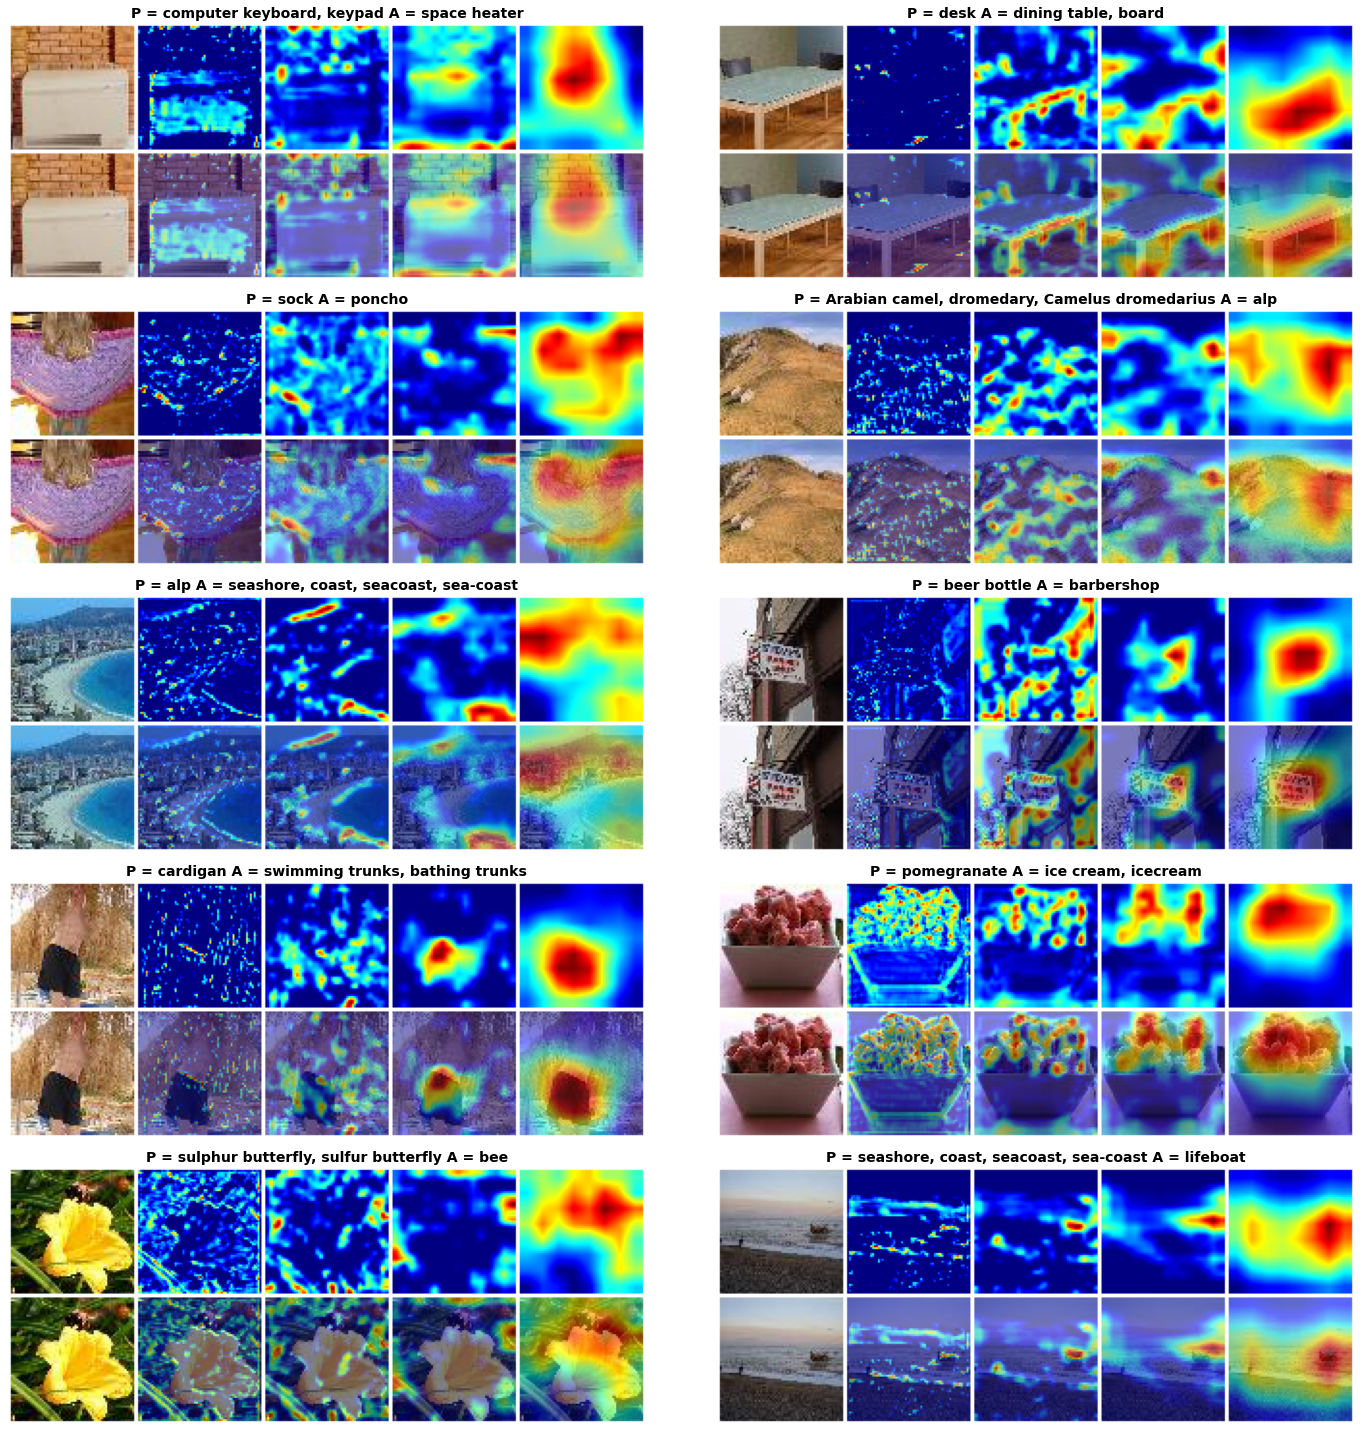

In [21]:
layers = [model.layer1,model.layer2,model.layer3,model.layer4]
ut.GradCamView(misclassified_images,model,words,layers,Figsize = (20,20),subplotx1 =5, subplotx2 = 2)